In [3]:
import os
import glob
import pandas as pd 
import numpy as np
#import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns
try :
    import nibabel as nib
except : 
    !pip install nibabel
    import nibabel as nib

from skimage.util import montage 
from skimage.transform import rotate
try : 
    import openxyl
except : 
    ! pip install openpyxl
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#%matplotlib notebook
from nilearn import surface, datasets, plotting
import nilearn
from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from IPython.display import display,Image
from scipy.stats import zscore

In [6]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII")
SCRIPT_PATH=os.path.join(STUDY_PATH,'scripts')
LOG_PATH=os.path.join(SCRIPT_PATH,'log')
#CQ_FILE=os.path.join(STUDY_PATH,'FairparkII_MRIData_20210622.xlsx')
CQ_FILE=os.path.join(STUDY_PATH,'FairparkII_MRIData_20210817.xlsx')

In [7]:
RES_FILE=os.path.join(STUDY_PATH,"resT2Struct.csv")
val = pd.read_csv(RES_FILE,index_col=0)
RES_FILE=os.path.join(STUDY_PATH,"resT2Struct_W00.csv")
val_W00 = pd.read_csv(RES_FILE,index_col=0)
RES_FILE=os.path.join(STUDY_PATH,"resT2Struct_W36.csv")
val_W36 = pd.read_csv(RES_FILE,index_col=0)

In [8]:
def getCQT1AndMultiTE(ptID):
    retT1=-1;retT2=-1
    CQData = pd.read_excel(CQ_FILE,index_col=0,engine='openpyxl')
    if ptID in CQData.index :
        if not np.isnan(CQData['QC_3DT1'][ptID]) : retT1=CQData['QC_3DT1'][ptID]
        if not np.isnan(CQData['QC_3DMULTI'][ptID]) : retT2=CQData['QC_3DMULTI'][ptID]
    return retT1,retT2 

In [9]:
CQData = pd.read_excel(CQ_FILE,index_col=0,engine='openpyxl')

In [10]:
glasser = fetch_parcellation("fsaverage5", "glasser", 360)
pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
mask = fetch_mask("fsaverage5")

In [15]:
df_W00=CQData.query("SUBJ.str.endswith('W00')")
df_W00.index=df_W00.index.str[:-8]
df_W36=CQData.query("SUBJ.str.endswith('W36')")
df_W36.index=df_W36.index.str[:-8]
df_CQ_FULL = pd.concat([df_W00.add_suffix('_W00'), df_W36.add_suffix('_W36')], axis=1)

In [16]:
df_CQ_FULL["GROUP"] = pd.NaT
GROUP_FILE=os.path.join(STUDY_PATH,"Group_FAIRPARK_CORR.xlsx")
GroupData = pd.read_excel(GROUP_FILE,index_col=0,engine='openpyxl')
GroupData.index=GroupData.index.astype(str)
for SUBJ in df_CQ_FULL.index:
    ptID=SUBJ[0]+SUBJ[2:6]   
    GRP=""
    if ptID in GroupData.index :
        if not np.isnan(GroupData['GROUPE_1_Deferiprone'][ptID]) :           
            df_CQ_FULL['GROUP'][SUBJ]=GroupData['GROUPE_1_Deferiprone'][ptID]
                
print(df_CQ_FULL)

          QC_3DT1_W00  QC_3DMULTI_W00  RV_CQ_ORIENTATION_W00  QC_3DT1_W36  \
SUBJ                                                                        
101001YM          3.0             4.0                    NaN          4.0   
101002GX          3.0             0.0                    NaN          3.0   
101003DM          4.0             4.0                    NaN          4.0   
101004NW          4.0             4.0                    NaN          4.0   
101005CT          4.0             4.0                    NaN          4.0   
...               ...             ...                    ...          ...   
703011AA          4.0             4.0                    NaN          4.0   
703012AA          4.0             4.0                    NaN         -1.0   
703013AA          4.0             4.0                    NaN          4.0   
101011VC          NaN             NaN                    NaN          4.0   
104003MA          NaN             NaN                    NaN          3.0   

/tmp/ipykernel_8726/1183194703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CQ_FULL['GROUP'][SUBJ]=GroupData['GROUPE_1_Deferiprone'][ptID]


# Surface mapping facon nilearn

In [17]:
#mylistFile=glob.glob(os.path.join(STUDY_PATH,'T2Maps','*R2*sub-*ses-W00_mni.nii.gz'))
#mylistFile.sort(key=lambda fichier: fichier.lower())
fsaverage_nii = nilearn.datasets.fetch_surf_fsaverage()
valR2_W00_PLA=[]
valR2_W36_PLA=[]
valR2_W00_DEF=[]
valR2_W36_DEF=[]
df_4test = df_CQ_FULL.query("(QC_3DT1_W00 > 1) & (QC_3DMULTI_W00 > 2) & (QC_3DT1_W36 > 1) & (QC_3DMULTI_W00 > 2) ")
for SUBJ in df_4test.index :
    #print(SUBJ)
    #SUBJ=file.split('/')[6].split("_")[2]
    file_W00=os.path.join(STUDY_PATH,'T2Maps',f'rRAS_R2Map_sub-{SUBJ}_ses-W00_mni.nii.gz')
    file_W36=os.path.join(STUDY_PATH,'T2Maps',f'rRAS_R2Map_sub-{SUBJ}_ses-W36_mni.nii.gz')
    if os.path.exists(file_W00) & os.path.exists(file_W36):
            
        img = nib.load(file_W00)
        texture_right = surface.vol_to_surf(img,fsaverage_nii.pial_right)
        texture_left  = surface.vol_to_surf(img,fsaverage_nii.pial_left)
        volOnSurface_W00 = np.concatenate([texture_left,texture_right], axis=0)

        img = nib.load(file_W36)
        texture_right = surface.vol_to_surf(img,fsaverage_nii.pial_right)
        texture_left  = surface.vol_to_surf(img,fsaverage_nii.pial_left)
        volOnSurface_W36 = np.concatenate([texture_left,texture_right], axis=0)
            
        if df_CQ_FULL.loc[SUBJ,'GROUP'] == 1 :
            valR2_W00_DEF.append(volOnSurface_W00)  
            valR2_W36_DEF.append(volOnSurface_W36)
        else :
            valR2_W00_PLA.append(volOnSurface_W00)  
            valR2_W36_PLA.append(volOnSurface_W36)
    else :
        print("eliminated")
        df_4test=df_4test.drop(SUBJ)

eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated
eliminated


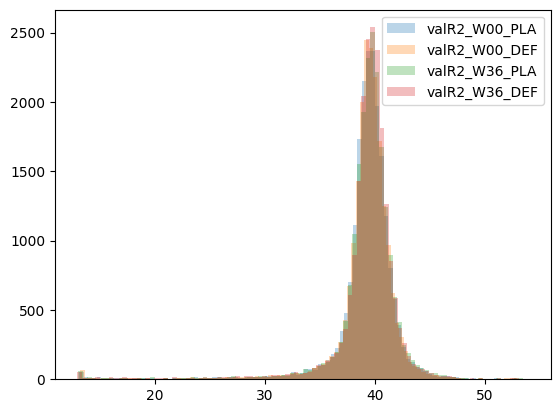

In [105]:
fig, ax = plt.subplots()

tmp=np.array(valR2_W00_PLA)
tmp_c=np.clip(tmp,np.quantile(tmp,0),np.quantile(tmp,0.99))
#tmp_z=zscore(tmp_c,axis=0)
tmp_d=np.median(tmp_c,axis=0)
ax.hist((1./tmp_d).ravel(),bins=100, alpha=0.3, label='valR2_W00_PLA')

tmp=np.array(valR2_W00_DEF)
tmp_c=np.clip(tmp,np.quantile(tmp,0),np.quantile(tmp,0.99))
#tmp_z=zscore(tmp_c,axis=0)
tmp_d=np.median(tmp_c,axis=0)
ax.hist((1./tmp_d).ravel(),bins=100, alpha=0.3, label='valR2_W00_DEF')

tmp=np.array(valR2_W36_PLA)
tmp_c=np.clip(tmp,np.quantile(tmp,0),np.quantile(tmp,0.99))
#tmp_z=zscore(tmp_c,axis=0)
tmp_d=np.median(tmp_c,axis=0)
ax.hist((1./tmp_d).ravel(),bins=100, alpha=0.3, label='valR2_W36_PLA')

tmp=np.array(valR2_W36_DEF)
tmp_c=np.clip(tmp,np.quantile(tmp,0),np.quantile(tmp,0.99))
#tmp_z=zscore(tmp_c,axis=0)
tmp_d=np.median(tmp_c,axis=0)
ax.hist((1./tmp_d).ravel(),bins=100, alpha=0.3, label='valR2_W36_DEF')
# Ajouter une légende
ax.legend()

# Afficher le graphique
plt.show()

In [77]:
tmp_d.shape

(20484,)

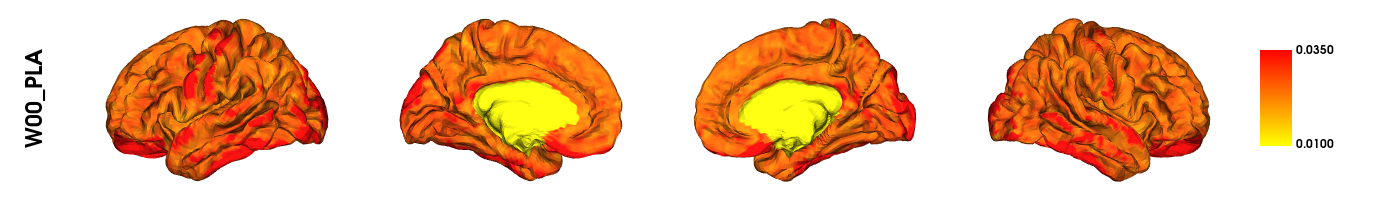

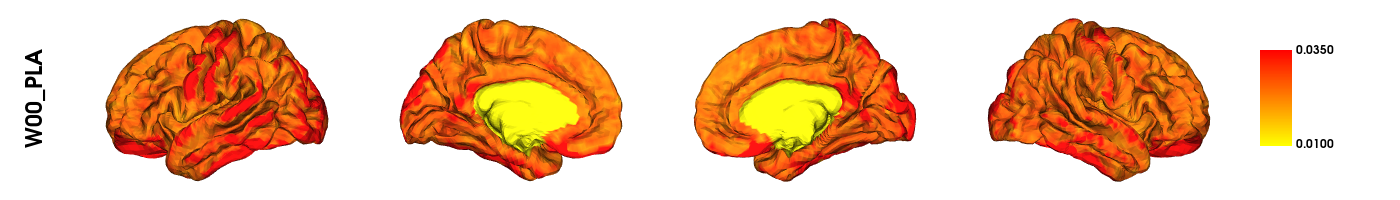

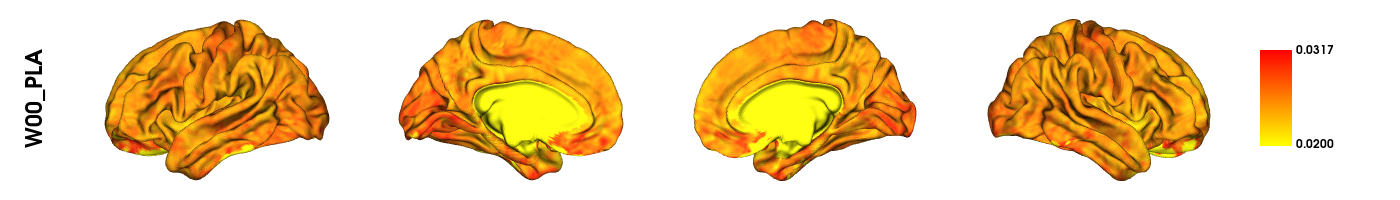

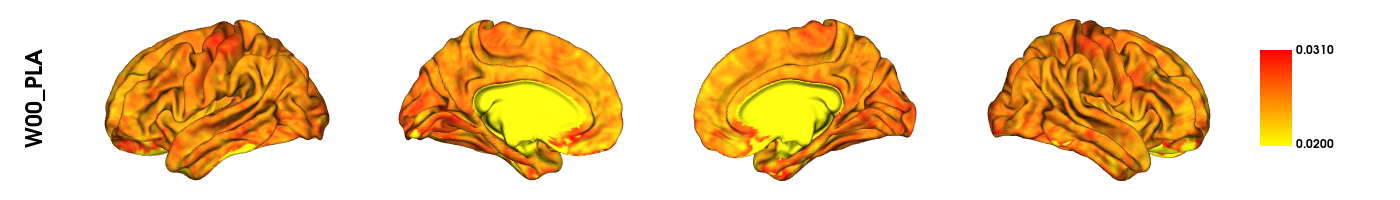

In [70]:
tmp=np.array(valR2_W00_PLA)
tmp_c=np.clip(tmp,np.quantile(tmp,0),np.quantile(tmp,0.99))
tmp_d=np.median(tmp_c,axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W00_PLA.png")
plot_hemispheres(pial_left,pial_right,tmp_d*mask, color_bar=True,color_range=(33,42),
    label_text=["W00_PLA"], cmap="autumn", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W00_DEF)
tmp_c=np.clip(tmp,np.quantile(tmp,0),np.quantile(tmp,0.99))
tmp_d=np.median(tmp_c,axis=0)
tmp_d=np.clip(np.mean(tmp_z,axis=0),-0.5,0.5)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W00_PLA.png")
plot_hemispheres(pial_left,pial_right,tmp[1,:]*mask, color_bar=True,color_range=(33,42),
    label_text=["W00_PLA"], cmap="autumn", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W00_PLA_2)[0:20,:]
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.clip(np.mean(tmp_z,axis=0),-0.5,0.5)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W00_PLA.png")
plot_hemispheres(pial_left_fslr32k,pial_right_fslr32k,np.clip(tmp,0.02,20)[1,:], color_bar=True,
    label_text=["W00_PLA"], cmap="autumn", embed_nb=True, size=(1400, 200),color_range=(33,42), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W36_PLA_2)[0:20,:]
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.clip(np.mean(tmp_z,axis=0),-0.5,0.5)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W00_PLA.png")
plot_hemispheres(pial_left_fslr32k,pial_right_fslr32k,np.clip(tmp,0.02,20)[1,:], color_bar=True,
    label_text=["W00_PLA"], cmap="autumn", embed_nb=True, size=(1400, 200),color_range=(33,42),
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))


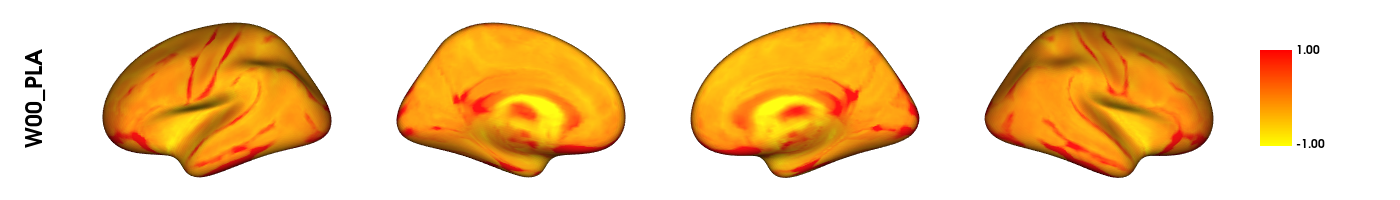

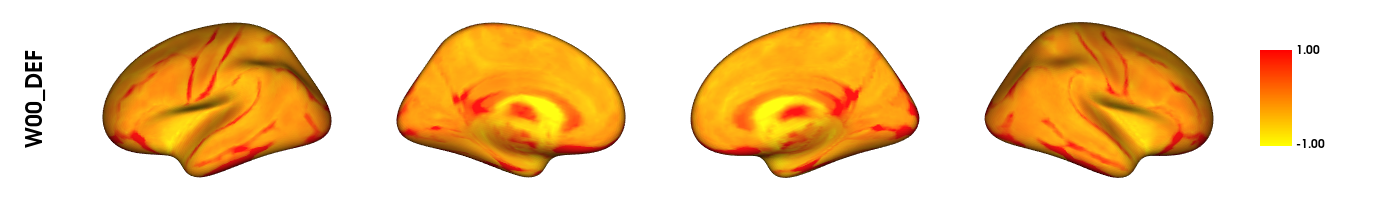

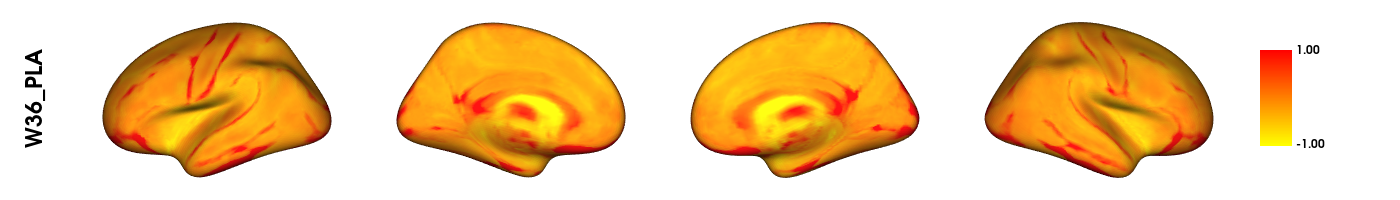

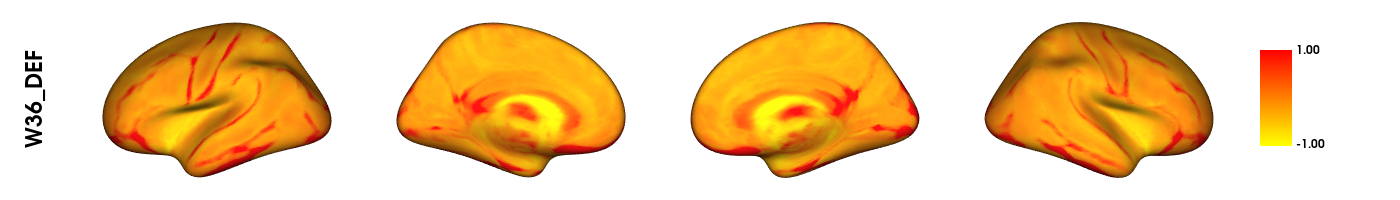

In [101]:
tmp=np.array(valR2_W00_PLA)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W00_PLA.png")
plot_hemispheres(inflated_left,inflated_right,tmp_d, color_bar=True,color_range=(-1,1),
    label_text=["W00_PLA"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W00_DEF)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W00_DEF.png")
plot_hemispheres(inflated_left,inflated_right,tmp_d, color_bar=True,color_range=(-1,1),
    label_text=["W00_DEF"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W36_PLA)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W36_PLA.png")
plot_hemispheres(inflated_left,inflated_right,tmp_d, color_bar=True,color_range=(-1,1),
    label_text=["W36_PLA"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W36_DEF)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_nilearn_W36_DEF.png")
plot_hemispheres(inflated_left,inflated_right,tmp_d, color_bar=True,color_range=(-1,1),
    label_text=["W36_DEF"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

In [22]:
    #data = img    
    #data_lh = nib.gifti.GiftiImage()
    #data_lh.add_gifti_data_array(nib.gifti.gifti.GiftiDataArray(data=data[:len(data)]))
    
    #data_rh = nib.gifti.GiftiImage()
    
    #r_filename_func = f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row[0]}_right_projection.func.gii"
    #l_filename_func = f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row[0]}_left_projection.func.gii"
    
    #nib.save(surface_gifti_right,r_filename_func)
    #nib.save(surface_gifti_left, l_filename_func)
    #print(f"{row[0]} sauvegardé")

    #plotting.plot_surf_stat_map(fsaverage["pial_right"], texture_right, hemi="right", vmin = 0, vmax = 100)
    #plotting.plot_surf_stat_map(fsaverage["pial_left"], texture_left, hemi = "left", vmin = 0, vmax = 100)
    #plotting.show()

### Surface Mapping facon wb

In [24]:
valR2_W00_PLA_2=[]
valR2_W36_PLA_2=[]
valR2_W00_DEF_2=[]
valR2_W36_DEF_2=[]
df_4test_2 = df_CQ_FULL.query("(QC_3DT1_W00 > 1) & (QC_3DMULTI_W00 > 3) & (QC_3DT1_W36 > 1) & (QC_3DMULTI_W00 > 3) ")
for SUBJ in df_4test.index :
    #SUBJ=file.split('/')[6].split("_")[2]   
    #file_W00=os.path.join(STUDY_PATH,'SurfaceMapping',f'sub-{SUBJ}_ses-W00',f'R2_sub-{SUBJ}_ses-W00.merged.dscalar.nii')
    #file_W36=os.path.join(STUDY_PATH,'SurfaceMapping',f'sub-{SUBJ}_ses-W36',f'R2_sub-{SUBJ}_ses-W36.merged.dscalar.nii')
    file_W00_L=os.path.join(STUDY_PATH,'SurfaceMapping',f'sub-{SUBJ}_ses-W00',f'R2.L.32k_fs_LR.shape.gii')
    file_W00_R=os.path.join(STUDY_PATH,'SurfaceMapping',f'sub-{SUBJ}_ses-W00',f'R2.R.32k_fs_LR.shape.gii')
    file_W36_L=os.path.join(STUDY_PATH,'SurfaceMapping',f'sub-{SUBJ}_ses-W36',f'R2.L.32k_fs_LR.shape.gii')
    file_W36_R=os.path.join(STUDY_PATH,'SurfaceMapping',f'sub-{SUBJ}_ses-W36',f'R2.R.32k_fs_LR.shape.gii')
    print(SUBJ)
    if os.path.exists(file_W00_L) & os.path.exists(file_W36_L):
        img_L = np.array(nib.load(file_W00_L).darrays[0].data)
        img_R = np.array(nib.load(file_W00_R).darrays[0].data)
        volOnSurface_W00 = np.concatenate([img_L,img_R], axis=0)
        #volOnSurface_W00[volOnSurface_W00<0.02]=0.02
        img_L = np.array(nib.load(file_W36_L).darrays[0].data)
        img_R = np.array(nib.load(file_W36_R).darrays[0].data)        
        volOnSurface_W36 = np.concatenate([img_L,img_R], axis=0)
        #volOnSurface_W00[volOnSurface_W00<0.02]=0.02    
        if df_CQ_FULL.loc[SUBJ,'GROUP'] == 1 :
            valR2_W00_DEF_2.append(volOnSurface_W00)  
            valR2_W36_DEF_2.append(volOnSurface_W36)
        else :
            valR2_W00_PLA_2.append(volOnSurface_W00)  
            valR2_W36_PLA_2.append(volOnSurface_W36)
    else :
        print("eliminated")
        df_4test_2=df_4test_2.drop(SUBJ)

101001YM
101003DM
101004NW
101005CT
101006BG
101007DG
101008NB
101012DE
101013FB
101016DC
101017IR
101018JW
101019HB
101024EL
101026DD
101028MM
101029VD
101030LG
101031WA
101032DA
101033SM
101034DF
101035BD
101037FN
101039KC
101041BA
101044WJ
101045MC
101047LW
101048TC
101049CD
101051DC
eliminated
101052AF
eliminated
101057GT
101058TN
102002XD
102004JM
102007PL
102008LB
102009AR
102011KV
102012JB
102013BG
102014JL
102015FL
102016JC
102018NG
103001MF
103002JW
103003FL
103004NV
103005SC
103006PD
103008OS
103010CA
103013JG
103014SA
103019HS
103021NW
103022DP
103023AH
103024JC
103025MP
103027RF
103028GD
103032MS
103033GF
104001PB
104006FH
104007FT
104011RG
104013YD
104014MJ
104016JS
104017JO
104019DB
104020DL
105001MA
105008FB
105009AM
105011JR
105012LB
105013SV
105014PD
105015CP
105018YL
105021RB
105022BC
105023MH
105026CD
105034AT
106001HB
106002FC
106003YT
106004ID
106005BD
106007MT
106008EH
106009OM
106010AG
106011BH
106012PP
106013BB
106014BS
106015HS
106017BV
106018BB
106019BP
106020

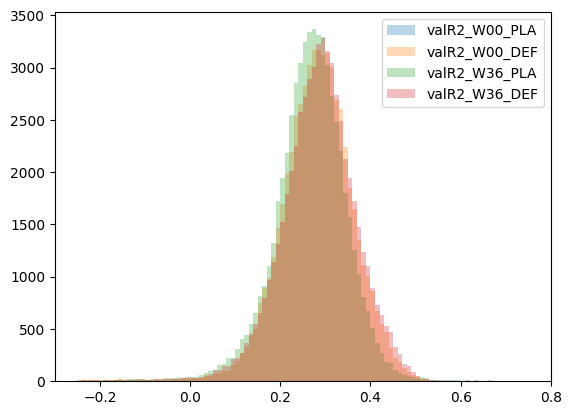

In [25]:
fig, ax = plt.subplots()

tmp=np.array(valR2_W00_PLA_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)
ax.hist(tmp_d.ravel(),bins=100,range=[-0.25,0.75], alpha=0.3, label='valR2_W00_PLA')

tmp=np.array(valR2_W00_DEF_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
has_nan = np.isnan(tmp_z).any(axis=1)
tmp_d=np.mean(tmp_z[~has_nan, :],axis=0)
ax.hist(tmp_d.ravel(),bins=100,range=[-0.25,0.75], alpha=0.3, label='valR2_W00_DEF')

tmp=np.array(valR2_W36_PLA_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)
ax.hist(tmp_d.ravel(),bins=100,range=[-0.25,0.75], alpha=0.3, label='valR2_W36_PLA')

tmp=np.array(valR2_W36_DEF_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
has_nan = np.isnan(tmp_z).any(axis=1)
tmp_d=np.mean(tmp_z[~has_nan, :],axis=0)
ax.hist(tmp_d.ravel(),bins=100,range=[-0.25,0.75], alpha=0.3, label='valR2_W36_DEF')

ax.legend()
plt.show()

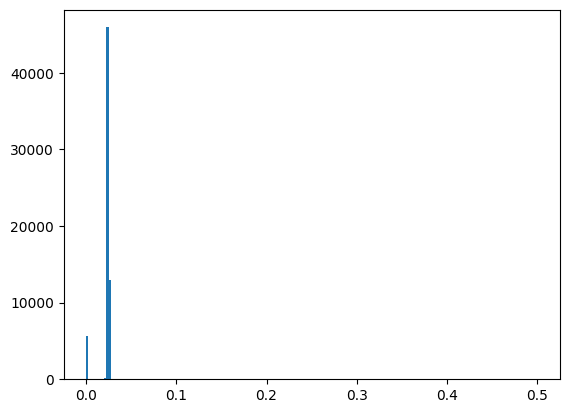

In [26]:
__=plt.hist(np.median(tmp[~has_nan, :],axis=0).ravel(),200,range=[0,0.5])

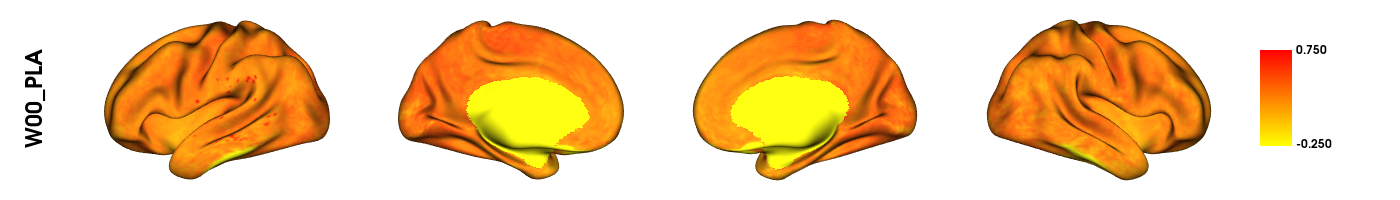

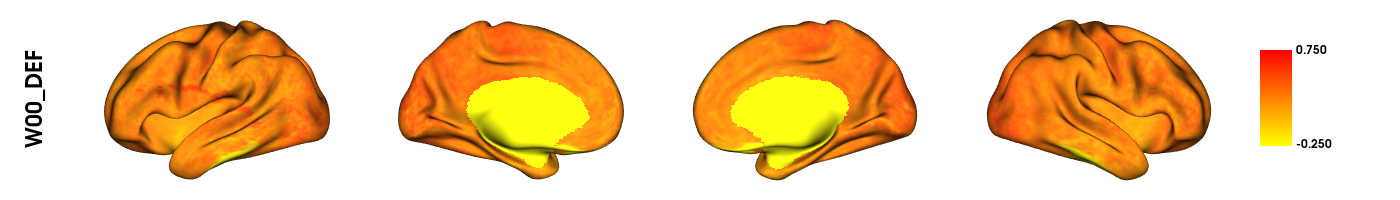

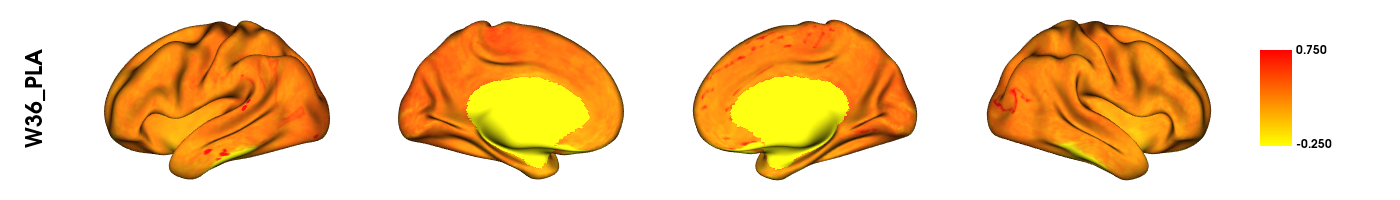

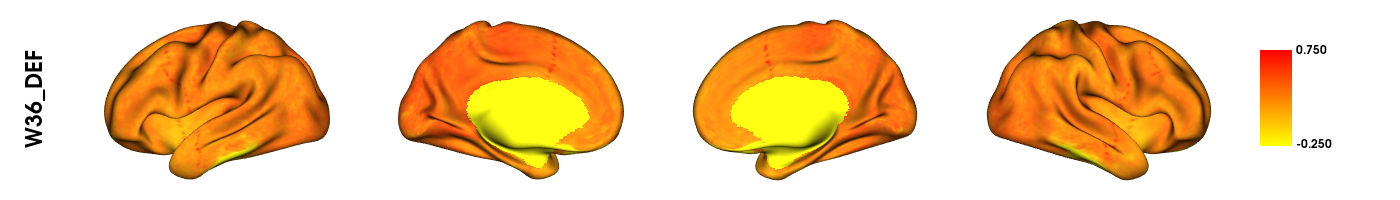

In [47]:
tmp=np.array(valR2_W00_PLA_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
has_nan = np.isnan(tmp_z).any(axis=1)
tmp_d=np.mean(tmp_z[~has_nan, :],axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_wb_W00_PLA.png")
plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,tmp_d, color_bar=True,color_range=(-0.25,0.75),
    label_text=["W00_PLA"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W00_DEF_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
has_nan = np.isnan(tmp_z).any(axis=1)
tmp_d=np.mean(tmp_z[~has_nan, :],axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_wb_W00_DEF.png")
plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,tmp_d, color_bar=True,color_range=(-0.25,0.75),
    label_text=["W00_DEF"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W36_PLA_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
has_nan = np.isnan(tmp_z).any(axis=1)
tmp_d=np.mean(tmp_z[~has_nan, :],axis=0)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_wb_W36_PLA.png")
plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,tmp_d, color_bar=True,color_range=(-0.25,0.75),
    label_text=["W36_PLA"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

tmp=np.array(valR2_W36_DEF_2)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
has_nan = np.isnan(tmp_z).any(axis=1)
tmp_d=np.mean(tmp_z[~has_nan, :],axis=0)
has_nan = np.isnan(tmp).any(axis=1)
figure_title=os.path.join(STUDY_PATH,"screenshots",f"R2_wb_W36_DEF.png")
plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,tmp_d, color_bar=True,color_range=(-0.25,0.75),
    label_text=["W36_DEF"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
    zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
    interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
display(Image(filename=figure_title))

In [33]:
df_4test['GROUP'] = df_4test['GROUP'].replace({1: 'DEF', 2: 'PLA'})
print(df_4test)

          QC_3DT1_W00  QC_3DMULTI_W00  RV_CQ_ORIENTATION_W00  QC_3DT1_W36  \
SUBJ                                                                        
101001YM          3.0             4.0                    NaN          4.0   
101003DM          4.0             4.0                    NaN          4.0   
101004NW          4.0             4.0                    NaN          4.0   
101005CT          4.0             4.0                    NaN          4.0   
101006BG          4.0             3.0                    NaN          4.0   
...               ...             ...                    ...          ...   
701001AA          4.0             3.0                    NaN          4.0   
703009AA          4.0             3.0                    NaN          4.0   
703010AA          4.0             4.0                    NaN          4.0   
703011AA          4.0             4.0                    NaN          4.0   
703013AA          4.0             4.0                    NaN          4.0   

## DEF vs PLA à WOO

In [29]:
val_R2=np.concatenate([np.array(valR2_W00_PLA),np.array(valR2_W00_DEF)],axis=0)
df_val=pd.concat([df_4test[df_4test['GROUP']=="PLA"],df_4test[df_4test['GROUP']=="DEF"]])

In [30]:
from brainstat.stats.terms import FixedEffect
term_group = FixedEffect(df_val.GROUP)
model_group = term_group
contrast_group = (df_val.GROUP == "PLA").astype(int) - (df_val.GROUP == "DEF").astype(
    int
)

In [31]:
from brainstat.stats.SLM import SLM
slm_group = SLM(
    model_group,
    contrast_group,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=True,
    cluster_threshold=0.05,
)
slm_group.fit(val_R2)

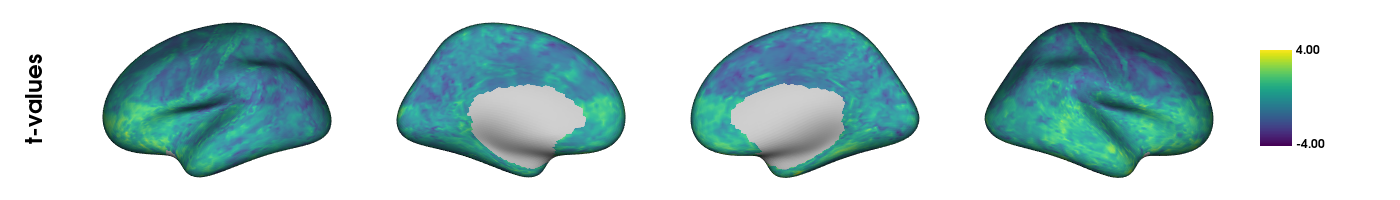

In [32]:
plot_hemispheres(inflated_left,inflated_right, slm_group.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=False)

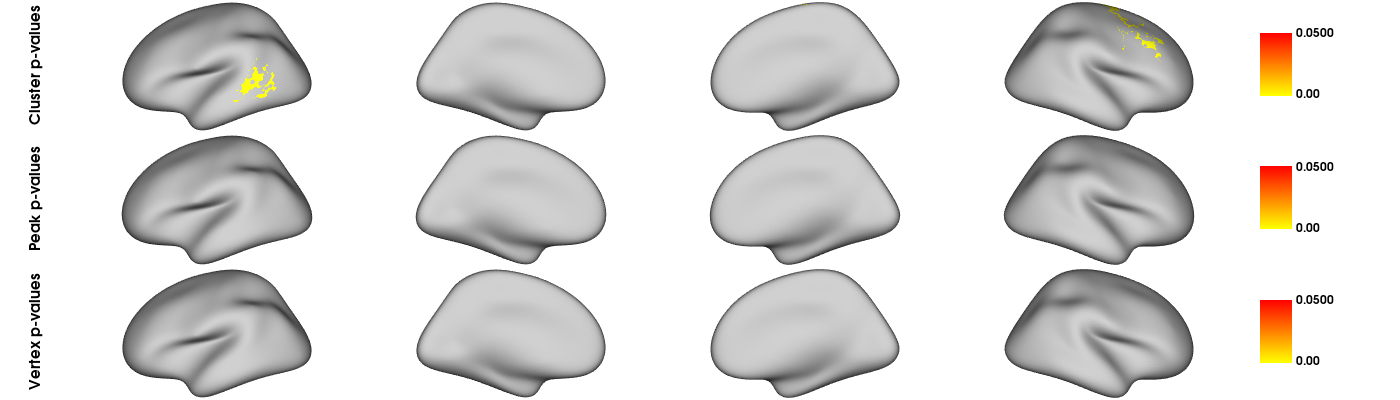

In [46]:
cp = [np.copy(slm_group.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_group.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_group.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])

plot_hemispheres(inflated_left,inflated_right,vals, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

## DEF vs PLA à W36

In [34]:
val_R2=np.concatenate([np.array(valR2_W36_PLA),np.array(valR2_W36_DEF)],axis=0)
df_val=pd.concat([df_4test[df_4test['GROUP']=="PLA"],df_4test[df_4test['GROUP']=="DEF"]])

In [35]:
from brainstat.stats.terms import FixedEffect
term_group = FixedEffect(df_val.GROUP)
model_group = term_group
contrast_group = (df_val.GROUP == "PLA").astype(int) - (df_val.GROUP == "DEF").astype(
    int
)

In [36]:
from brainstat.stats.SLM import SLM
slm_group = SLM(
    model_group,
    contrast_group,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=True,
    cluster_threshold=0.05,
)
slm_group.fit(val_R2)

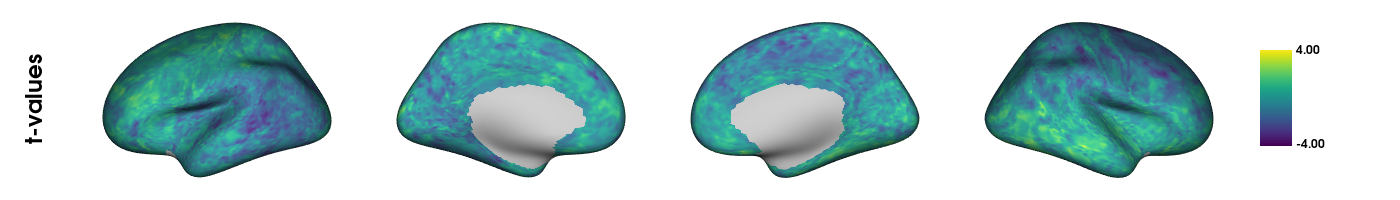

In [37]:
plot_hemispheres(inflated_left,inflated_right,slm_group.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=False)

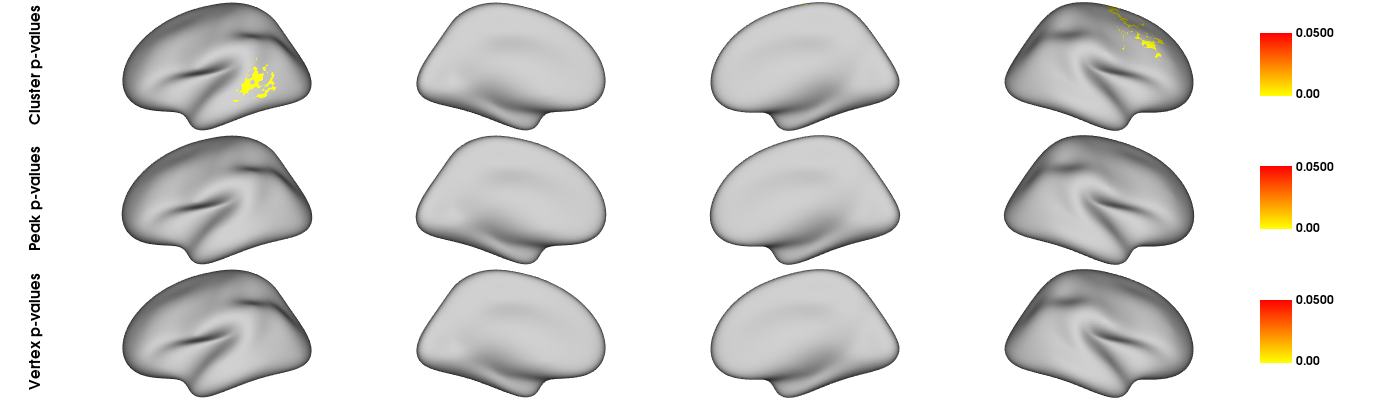

In [38]:
cp = [np.copy(slm_group.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_group.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_group.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])

plot_hemispheres(inflated_left,inflated_right,vals, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

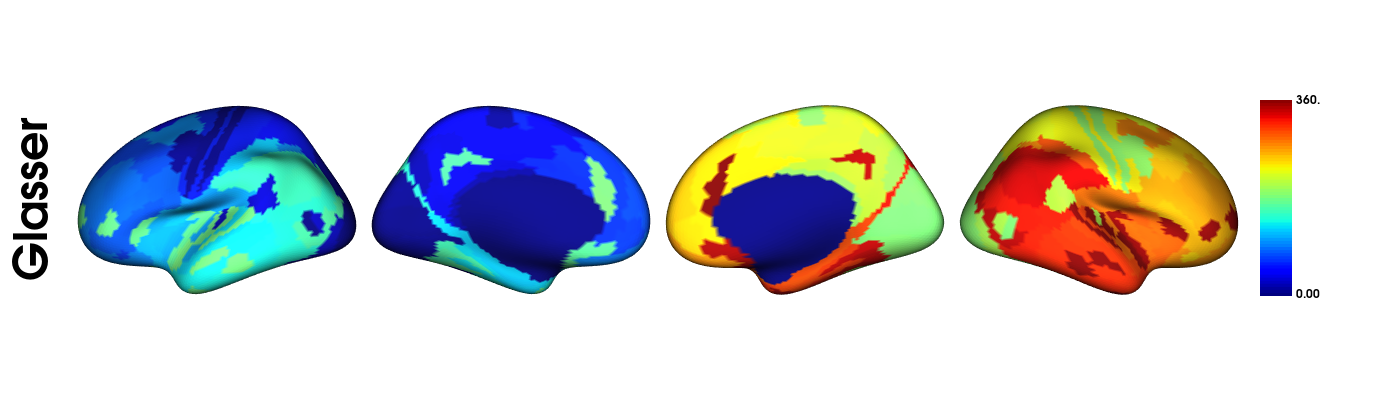

In [39]:
plot_hemispheres(inflated_left,inflated_right,glasser, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

nan nan
nan nan
nan nan
nan nan


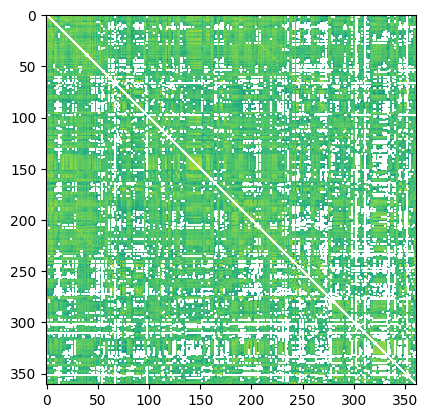

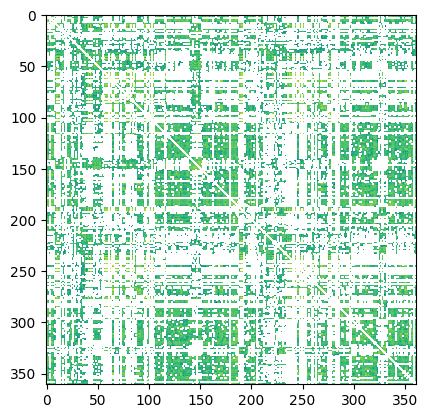

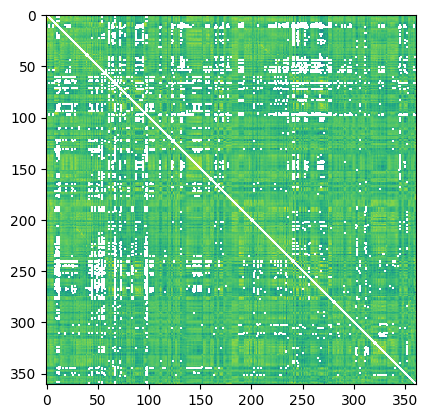

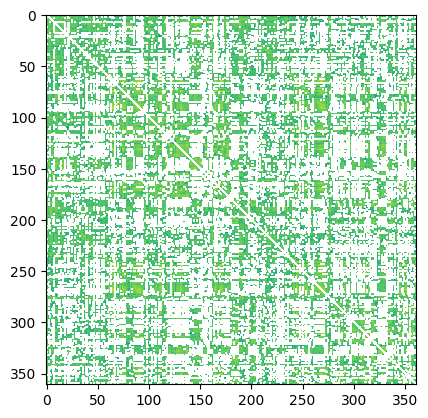

In [35]:
import scipy.special
for nd in valR2_W00_PLA,valR2_W00_DEF,valR2_W36_PLA,valR2_W36_DEF:
    ndtmp=np.array(nd)
    resultats = np.zeros((ndtmp.shape[0],361))
    for cpt,ligne in enumerate(ndtmp):
        resultats[cpt,:]=[np.median(ligne[glasser==x])for x in np.unique(glasser)]
    resultats_c=np.clip(resultats,np.quantile(resultats,0.01),np.quantile(resultats,0.99))
    #plt.figure();__=plt.hist(resultats.ravel(),200,range=[0,0.1])
    #plt.figure();__=plt.hist(resultats_z.ravel(),200,range=[-1.5,1])
    
#resultats_z=zscore(resultats_c,axis=0)
    #cov = np.cov(np.transpose(resultats_c))
    cov=np.corrcoef(np.transpose(resultats_c))
#resultats_z=zscore(resultats_c,axis=0)
    #cov=zscore(covt,axis=0)
    for i in range(len(cov)):
        cov[i, i] = 0
    cov_fisher = scipy.special.logit(cov)
    #plt.figure();__=plt.hist(cov.ravel(),200,range=[-.25,0.25])
    plt.figure()
    print(np.min(cov_fisher.ravel()),np.max(cov_fisher.ravel()))
    plt.imshow(cov_fisher)
    #plt.figure()
    #plt.imshow(cov_fisher)

(70, 360)

In [42]:
df_cort = pd.read_excel(os.path.join("/NAS","tupac","protocoles","PULSE",'df_glasser360.xlsx'))
cols=[col[8:] for col in df_cort.filter(regex="Mediane").columns]
df = pd.DataFrame(resultats_c[:,1:], index=df_4test[df_4test['GROUP']=="DEF"].index, columns=cols)

ValueError: Shape of passed values is (70, 361), indices imply (70, 360)

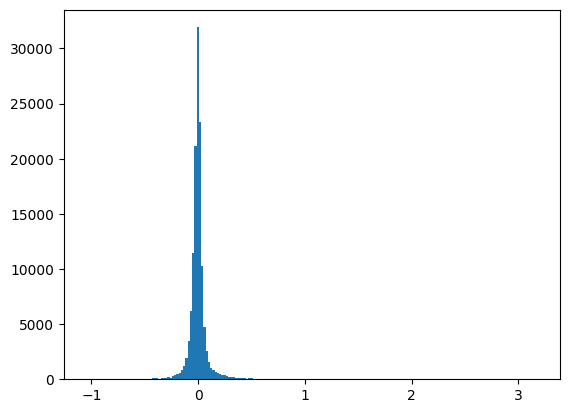

In [41]:
__=plt.hist(cov.ravel(),200)

In [42]:
import networkx as nx

G = nx.from_numpy_array(cov)
# Vérifier les nœuds et les arêtes du graph
partition=nx.community.louvain_communities(G, seed=123)

# Appliquer l'algorithme de Louvain à l'aide de networkx
partition = nx.algorithms.community.louvain_communities(G)

# Obtenir les communautés
communities = {value: list(nodes) for value, nodes in enumerate(partition)}
# Réorganiser la matrice de connectivité en fonction des communautés
reordered_nodes = sorted(G.nodes(), key=lambda x: next(value for value, nodes in communities.items() if x in nodes))
reordered_matrix = cov[np.ix_(reordered_nodes, reordered_nodes)]

print("Matrice de connectivité réorganisée :")
print(reordered_matrix)

Matrice de connectivité réorganisée :
[[ 0.          0.020239   -0.09190056 ...  0.00727719  0.01437246
  -0.07115775]
 [ 0.020239    0.          0.02878431 ... -0.02963911 -0.18426718
   0.00251062]
 [-0.09190056  0.02878431  0.         ... -0.05350005 -0.35230976
   0.03588754]
 ...
 [ 0.00727719 -0.02963911 -0.05350005 ...  0.          0.16205093
  -0.04554598]
 [ 0.01437246 -0.18426718 -0.35230976 ...  0.16205093  0.
  -0.22162638]
 [-0.07115775  0.00251062  0.03588754 ... -0.04554598 -0.22162638
   0.        ]]


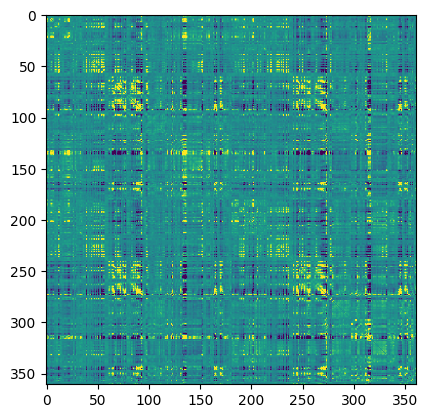

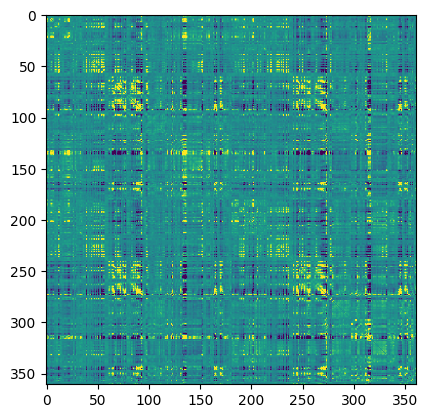

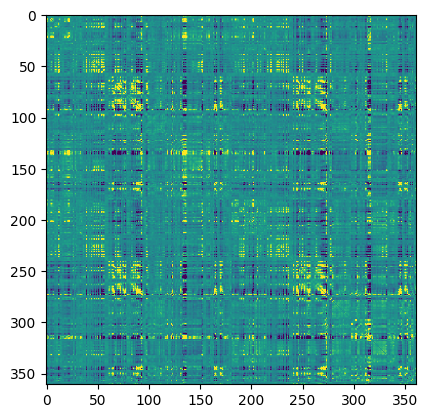

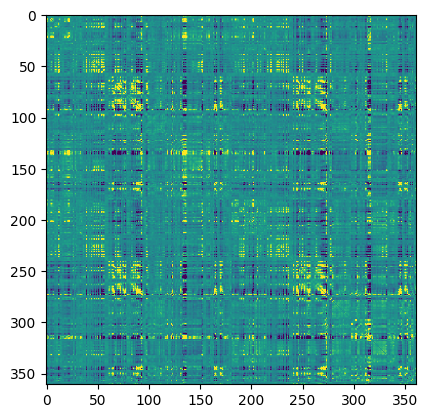

In [44]:
for nd in valR2_W00_PLA_2,valR2_W00_DEF_2,valR2_W36_PLA_2,valR2_W36_DEF_2:
    ndtmp=np.array(valR2_W00_PLA)
    resultats = np.zeros((ndtmp.shape[0],361))
    for cpt,ligne in enumerate(ndtmp):
        resultats[cpt,:]=[np.mean(ligne[glasser==x])for x in np.unique(glasser)]
    resultats_c=np.clip(resultats,np.quantile(resultats,0.01),np.quantile(resultats,0.99))
    #plt.figure();__=plt.hist(resultats.ravel(),200,range=[0,0.1])
    resultats_z=zscore(resultats_c,axis=1)
    #plt.figure();__=plt.hist(resultats_z.ravel(),200,range=[-1.5,1])
    cov = np.cov(np.transpose(resultats_z))
    for i in range(len(cov)):
        cov[i, i] = 0
    #plt.figure();__=plt.hist(cov.ravel(),200,range=[-.25,0.25])
    plt.figure()
    plt.imshow(cov,vmin=-0.25,vmax=0.25)

In [107]:
CQ_FILE=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII","resT2Struct_W00.csv")
val_W00 = pd.read_csv(CQ_FILE,index_col=0)
CQ_FILE=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII","resT2Struct_W36.csv")
val_W36 = pd.read_csv(CQ_FILE,index_col=0)

GPe_L      GPe_R      GPi_L      GPi_R       RN_L  \
SUBJ                                                                  
sub-105011JR  33.529785  32.959633  34.542391  34.149767  31.565596   
sub-105021RB  30.462797  29.150225  31.706455  29.284436  33.059411   
sub-201018AA  25.428415  24.915382  30.521336  28.586641  37.708313   
sub-105013SV  29.583501  29.403173  34.493862  31.749005  34.210988   
sub-703013AA  24.990652  22.316916  30.317135  25.061063  28.356572   
...                 ...        ...        ...        ...        ...   
sub-101017IR  27.973543  28.867583  31.450058  29.602168  28.143002   
sub-102002XD  29.451933  29.202859  35.046711  33.813758  35.759039   
sub-603002FB  31.104420  27.079106  39.494814  35.280824  35.613383   
sub-101003DM  26.955405  28.647653  28.833497  32.705641  29.236643   
sub-108004DC  32.266242  29.715158  41.102807  35.765602  35.178686   

                   RN_R       SN_L       SN_R      STh_L      STh_R  ...  \
SUBJ                                                                 ...   
sub-105011JR  30.527578  30.650347  29.364582  35.235676  30.402560  ...   
sub-105021RB  31.710481  27.138527  26.570820  32.966534  29.734412  ...   
sub-201018AA  36.832257  26.627348  27.324820  37.617439  30.659964  ...   
sub-105013SV  32.783099  30.058694  29.858970  34.995902  31.637152  ...   
sub-703013AA  23.832871  17.523515  20.025642  24.490239  20.801403  ...   
...                 ...        ...        ...        ...        ...  ...   
sub-101017IR  29.091274  28.111119  31.529654  27.201611  27.387747  ...   
sub-102002XD  35.202075  32.158144  32.018617  34.162334  29.265473  ...   
sub-603002FB  29.129717  23.211678  25.553214  38.802164  29.713212  ...   
sub-101003DM  29.663597  25.938298  28.388402  27.056393  29.927238  ...   
sub-108004DC  34.127648  32.999838  33.897520  33.250674  28.757289  ...   

              Left_thalamus  Right_thalamus  Left_globus_pallidus  \
SUBJ                                                                
sub-105011JR      38.480440       38.886141             31.240696   
sub-105021RB      36.321661       35.977463             29.073187   
sub-201018AA      39.506503       39.093188             23.157820   
sub-105013SV      37.703299       37.832819             28.138591   
sub-703013AA      36.941884       36.581456             20.297814   
...                     ...             ...                   ...   
sub-101017IR      40.802460       40.542800             26.667956   
sub-102002XD      38.133234       37.812142             27.036339   
sub-603002FB      39.237705       37.734925             26.731753   
sub-101003DM      38.141329       39.358228             26.860187   
sub-108004DC      42.317463       41.313954             25.811982   

              Right_globus_pallidus  Left_hipocampus  Right_hipocampus  \
SUBJ                                                                     
sub-105011JR              31.158134        42.015720         41.822772   
sub-105021RB              28.187231        40.998160         42.787193   
sub-201018AA              23.922696        43.268631         43.697583   
sub-105013SV              28.409819        40.684425         40.476454   
sub-703013AA              20.532872        42.410826         42.688369   
...                             ...              ...               ...   
sub-101017IR              26.564543        39.296847         44.750945   
sub-102002XD              28.002572        41.860030         41.036802   
sub-603002FB              25.246224        40.800478         41.261299   
sub-101003DM              26.162693        38.922006         39.948187   
sub-108004DC              28.411755        43.801300         42.098740   

              Left_amigdala  Right_amigdala  Left_accumbens  Right_accumbens  
SUBJ                                                                          
sub-105011JR      44.284694       43.374030       43.682821        43.654714  
sub-105

In [432]:
data = []
for cpt,SUBJ in enumerate(['105009AM']): #enumerate(df_val.index):
    for SES in ['W00','W36']:
        print(SUBJ)
        file_CER=os.path.join(STUDY_PATH,'Atlas_Seg',f'sub-{SUBJ}_ses-{SES}',f'Cerebellum-SUIT_sub-{SUBJ}_ses-{SES}_on3DT1.nii.gz')
        if (not os.path.exists(file_CER)) :
            print(f'fichier file_SEG manquant pour {SUBJ} {cpt}')
        CER=nib.load(file_CER).get_fdata()
        file_R2=os.path.join(STUDY_PATH,'T2Maps',f'rRAS_T2Map_sub-{SUBJ}_ses-{SES}.nii.gz')
        if (not os.path.exists(file_R2)) :        
            print(f'fichier file_R2 manquant pour {SUBJ} {cpt}')
        R2=nib.load(file_R2).get_fdata()
        file_R2_mni=os.path.join(STUDY_PATH,'T2Maps',f'rRAS_T2Map_sub-{SUBJ}_ses-{SES}.nii.gz')
        if (not os.path.exists(file_R2_mni)) :        
            print(f'fichier file_R2_mni manquant pour {SUBJ} {cpt}')        
        R2_mni=nib.load(file_R2_mni).get_fdata()
        file_VOL=glob.glob(os.path.join(STUDY_PATH,'Volbrain_Seg_V2',f'sub_{SUBJ}_ses_{SES}','native_structures_std_native_*.nii.gz'))[0]
        if (not os.path.exists(file_VOL)) :
            print(f'fichier Volbrain manquant pour {SUBJ} {cpt}')
        VOL=nib.load(file_VOL).get_fdata()
                
        #Volbrain
        val_vol=[np.median(R2[VOL==x])for x in np.unique(VOL)]
        
        #Cerebellum
        val_cer=[np.median(R2[CER==x])for x in np.unique(CER)]
        print(np.unique(CER))
        #Keuken
        l_sscor=glob.glob(os.path.join(STUDY_PATH,'Atlas_Seg',f'sub-{SUBJ}_ses-{SES}','*_std_ras.nii.gz'))
        keuken=list()
        for file in l_sscor:
            SEG=nib.load(file).get_fdata()
            keuken.append(np.sum(np.multiply(SEG,R2))/np.sum(SEG))
        val_keu=np.array(keuken)
        
        #Glasser            
        print(np.hstack([val_vol,val_cer,val_keu]).shape[0])
        df_tableau = pd.DataFrame(np.hstack([val_vol,val_cer,val_keu]).reshape(1, -1), columns=[f"Colonne_{i+1}" for i in range(np.hstack([val_vol,val_cer,val_keu]).shape[0])]) # Convertit le tableau en DataFrame
        df_tableau.insert(0, "Nom_sujet", SUBJ) # Ajoute la colonne "Nom_sujet" en première position
        df_tableau.insert(1, "Session", SES) # Ajoute la colonne "Groupe" en deuxième position
        data.append(df_tableau) # Ajoute le DataFrame à la liste

105009AM
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
179
105009AM
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]
180


In [292]:
medianeR2_lat_sscort=pd.concat(data, ignore_index=True)
#medianeR2_lat_sscort.to_csv(os.path.join(STUDY_PATH,"medianeR2_lat_sscort.csv"))

In [293]:
nouveaux_noms = ["SUBJ_ID","SES","EXT_VOL","3rd ventricle","4th ventricle","Right accumbens","Left accumbens","Left amygdala","Right amygdala","Brainstem","Right caudate","Left caudate","Right cerebellum exterior","Left cerebellum exterior","Right cerebellum White Matter","Left cerebellum White Matter","Right cerebral White Matter","Left cerebral White Matter","Right hippocampus","Left hippocampus","Right inf. lateral ventricle","Left inf. lateral ventricle","Right lateral ventricle","Left lateral ventricle","Right pallidum","Left pallidum","Right putamen","Left putamen","Right thalamus","Left thalamus","Right ventral DC","Left ventral DC","Lobules I-V","Lobules VI-VII","Lobules VIII-X","Left basal forebrain","Right basal forebrain","Right anterior cingulate gyrus","Left anterior cingulate gyrus","Right anterior insula","Left anterior insula","Right anterior orbital gyrus","Left anterior orbital gyrus","Right angular gyrus","Left angular gyrus","Right calcarine cortex","Left calcarine cortex","Right central operculum","Left central operculum","Right cuneus","Left cuneus","Right entorhinal area","Left entorhinal area","Right frontal operculum","Left frontal operculum","Right frontal pole","Left frontal pole","Right fusiform gyrus","Left fusiform gyrus","Right gyrus rectus","Left gyrus rectus","Right inf. occipital gyrus","Left inf. occipital gyrus","Right inf. temporal gyrus","Left inf. temporal gyrus","Right lingual gyrus","Left lingual gyrus","Right lateral orbital gyrus","Left lateral orbital gyrus","Right middle cingulate gyrus","Left middle cingulate gyrus","Right medial frontal cortex","Left medial frontal cortex","Right middle frontal gyrus","Left middle frontal gyrus","Right middle occipital gyrus","Left middle occipital gyrus","Right medial orbital gyrus","Left medial orbital gyrus","Right postcentral gyrus medial segment","Left postcentral gyrus medial segment","Right precentral gyrus medial segment","Left precentral gyrus medial segment","Right sup. frontal gyrus medial segment","Left sup. frontal gyrus medial segment","Right middle temporal gyrus","Left middle temporal gyrus","Right occipital pole","Left occipital pole","Right occipital fusiform gyrus","Left occipital fusiform gyrus","Right opercular inf. frontal gyrus","Left opercular inf. frontal gyrus","Right orbital inf. frontal gyrus","Left orbital inf. frontal gyrus","Right posterior cingulate gyrus","Left posterior cingulate gyrus","Right precuneus","Left precuneus","Right parahippocampal gyrus","Left parahippocampal gyrus","Right posterior insula","Left posterior insula","Right parietal operculum","Left parietal operculum","Right postcentral gyrus","Left postcentral gyrus","Right posterior orbital gyrus","Left posterior orbital gyrus","Right planum polare","Left planum polare","Right precentral gyrus","Left precentral gyrus","Right planum temporale","Left planum temporale","Right subcallosal area","Left subcallosal area","Right sup. frontal gyrus","Left sup. frontal gyrus","Right supplementary motor cortex","Left supplementary motor cortex","Right supramarginal gyrus","Left supramarginal gyrus","Right sup. occipital gyrus","Left sup. occipital gyrus","Right sup. parietal lobule","Left sup. parietal lobule","Right sup. temporal gyrus","Left sup. temporal gyrus","Right temporal pole","Left temporal pole","Right triangular inf. frontal gyrus","Left triangular inf. frontal gyrus","Right transverse temporal gyrus","Left transverse temporal gyrus","EXT_CER","Left_I_IV","Right_I_IV","Left_V","Right_V","Left_VI","Vermis_VI","Right_VI","Left_CrusI","Vermis_CrusI","Right_CrusI","Left_CrusII","Vermis_CrusII","Right_CrusII","Left_VIIb","Vermis_VIIb","Right_VIIb","Left_VIIIa","Vermis_VIIIa","Right_VIIIa","Left_VIIIb","Vermis_VIIIb","Right_VIIIb","Left_IX","Vermis_IX","Right_IX","Left_X","Vermis_X","Right_X","Left_Dentate","Right_Dentate","Left_Interposed","Right_Interposed","Left_Fastigial","Right_Fastigial","Right RN","Left Gpi","Left Gpe","Right STR","Right Gpi","Right SN","Left RN","Left SN","Right Sth","Left Sth","Right Gpe","Left STR"]
# Création d'un dictionnaire qui mappe les anciens noms de colonnes aux nouveaux noms de colonnes
renommage = {ancien_nom: nouveau_nom for ancien_nom, nouveau_nom in zip(medianeR2_lat_sscort.columns, nouveaux_noms)}
df = medianeR2_lat_sscort.rename(columns=renommage)

In [4]:
df.to_csv(os.path.join(STUDY_PATH,"medianeR2_lat_sscort.csv"))

NameError: name 'df' is not defined

In [325]:
tmp=np.array(valR2_W36_DEF)
tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
tmp_z=zscore(tmp_c,axis=1)
tmp_d=np.mean(tmp_z,axis=0)

In [11]:
df=pd.read_csv(os.path.join(STUDY_PATH,"medianeR2_lat_sscort.csv"))

In [12]:
df

SUBJ_ID  SES    EXT_VOL  3rd ventricle  4th ventricle  Right accumbens  \
0    101001YM  W00  26.671371      55.032127      53.111736        37.857849   
1    101001YM  W36  25.869984      53.621082      52.870773        39.262102   
2    101005CT  W00  26.661168      52.703577      54.321203        36.435677   
3    101005CT  W36  29.976559      53.447159      47.769991        38.942524   
4    101008NB  W00  35.061817      53.788792      48.819763        41.073589   
..        ...  ...        ...            ...            ...              ...   
291  503012EC  W36  35.066910      54.021019      47.126667        41.808441   
292  703009AA  W00  49.852135      53.361565      53.399324        39.078396   
293  703009AA  W36  47.443277      54.808104      53.256859        39.400425   
294  703011AA  W00  49.484459      56.150600      54.026968        36.480225   
295  703011AA  W36  51.195185      51.931717      57.711725        36.427961   

     Left accumbens  Left amygdala  Right amygdala  Brainstem  ...   Left Gpe  \
0         36.904221      41.751831       41.959473  38.290710  ...  38.797575   
1         39.489124      43.647110       43.569370  37.442692  ...  29.173583   
2         36.648731      41.990822       43.018894  38.052917  ...  33.215834   
3         36.841467      41.509966       42.249371  36.843895  ...  29.878701   
4         39.216953      42.609062       43.233570  37.124619  ...  26.657322   
..              ...            ...             ...        ...  ...        ...   
291       41.133694      41.069023       44.794046  38.809124  ...  29.449014   
292       35.875896      42.497093       42.234016  39.284294  ...  32.512435   
293       38.992645      44.531000       43.443996  37.323961  ...  36.942240   
294       38.837662      40.791973       48.145845  38.498728  ...  29.553936   
295       39.578432      43.173328       43.137012  38.861423  ...  26.804257   

     Right STR  Right Gpi   Right SN    Left RN    Left SN  Right Sth  \
0    28.215818  23.085628  31.218639  28.495203  28.615018  29.652141   
1    28.940251  38.837408  25.462622  23.494534  23.186133  37.597854   
2    28.906749  23.691785  29.606735  32.981286  26.298565  28.715208   
3    27.519523  33.903503  24.723703  33.935529  33.448115  29.923873   
4    31.800405  31.723659  35.762153  30.070399  31.893028  27.827339   
..         ...        ...        ...        ...        ...        ...   
291  28.688043  35.937170  39.073628  36.687647  30.602041  40.261774   
292  30.507629  25.020368  34.972086  35.638997  25.233972  27.346000   
293  35.863237  35.898684  37.490396  37.956171  37.655734  34.380997   
294  32.444009  34.485838  39.628701  36.568427  41.326449  31.985671   
295  33.853271  28.745216  28.508728  35.179821  29.558479  26.980382   

      Left Sth  Right Gpe   Left STR  
0    36.400198  30.727421  25.678018  
1    29.993993  27.408011  28.538995  
2    33.442097  32.407533  26.435852  
3    33.437117  26.079030  30.161251  
4    32.297903  35.533382  31.154901  
..         ...        ...        ...  
291  43.483179  45.881831  36.707309  
292  22.593901  29.469577  32.620220  
293  40.630921  29.112126  37.807949  
294  35.221966  32.241933  35.906138  
295  33.920949  25.889789  38.833496  

[296 rows x 182 columns]

In [332]:
for nd in valR2_W00_PLA:#,valR2_W00_DEF,valR2_W36_PLA,valR2_W36_DEF:
    ndtmp=np.array(nd)
    resultats = np.zeros((ndtmp.shape[0],361))
    for cpt,ligne in enumerate(ndtmp):
        resultats[cpt,:]=[np.mean(ligne[glasser==x])for x in np.unique(glasser)]
    resultats_c=np.clip(resultats,np.quantile(resultats,0.01),np.quantile(resultats,0.99))
    #plt.figure();__=plt.hist(resultats.ravel(),200,range=[0,0.1])
    #plt.figure();__=plt.hist(resultats_z.ravel(),200,range=[-1.5,1])
    
#resultats_z=zscore(resultats_c,axis=0)
    #cov = np.cov(np.transpose(resultats_c))
    #cov=np.corrcoef(np.transpose(resultats_c))

IndexError: invalid index to scalar variable.

<Axes: >

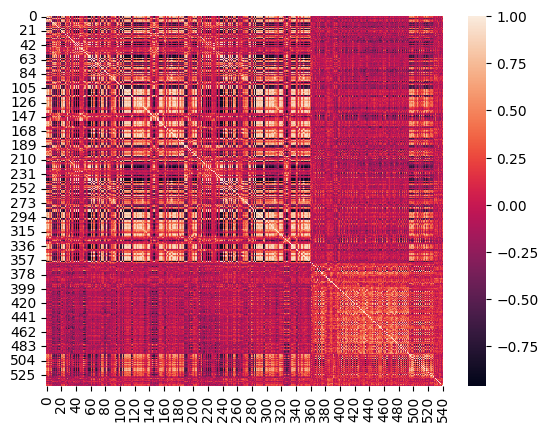

In [418]:
ndtmp=np.array(valR2_W00_DEF)
resultats = np.zeros((ndtmp.shape[0],361))
for cpt,ligne in enumerate(ndtmp):
    resultats[cpt,:]=[np.mean(ligne[glasser==x])for x in np.unique(glasser)]

set_DEF=set(df_val[df_val['GROUP']=='DEF'].index)
tmp=df[df['SUBJ_ID'].isin(set_DEF)]

mat=np.concatenate([resultats,tmp[tmp['SES']=='W00'].drop(columns=['SUBJ_ID','SES']).values],axis=1)
cov=np.corrcoef(np.transpose(mat))
   # for i in range(len(cov)):
   #     cov[i, i] = 0
   # cov_fisher = scipy.special.logit(cov)
    #plt.figure();__=plt.hist(cov.ravel(),200,range=[-.25,0.25])
    #plt.figure()
    #print(np.min(cov.ravel()),np.max(cov_fisher.ravel()))
    #plt.imshow(cov_fisher)
sns.heatmap(cov)

<Axes: >

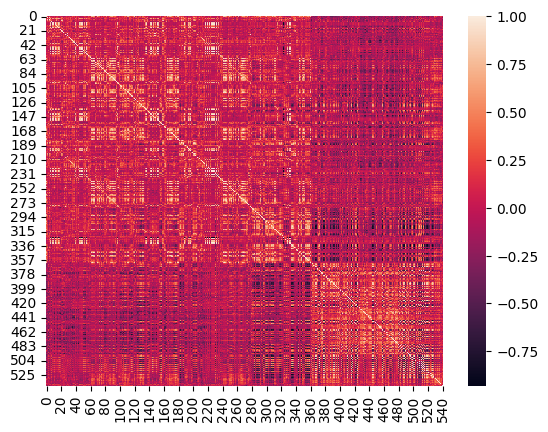

In [419]:
ndtmp=np.array(valR2_W36_DEF)
resultats = np.zeros((ndtmp.shape[0],361))
for cpt,ligne in enumerate(ndtmp):
    resultats[cpt,:]=[np.mean(ligne[glasser==x])for x in np.unique(glasser)]

set_DEF=set(df_val[df_val['GROUP']=='DEF'].index)
tmp=df[df['SUBJ_ID'].isin(set_DEF)]

mat=np.concatenate([resultats,tmp[tmp['SES']=='W36'].drop(columns=['SUBJ_ID','SES']).values],axis=1)
cov=np.corrcoef(np.transpose(mat))
   # for i in range(len(cov)):
   #     cov[i, i] = 0
   # cov_fisher = scipy.special.logit(cov)
    #plt.figure();__=plt.hist(cov.ravel(),200,range=[-.25,0.25])
    #plt.figure()
    #print(np.min(cov.ravel()),np.max(cov_fisher.ravel()))
    #plt.imshow(cov_fisher)
sns.heatmap(cov)

<Axes: >

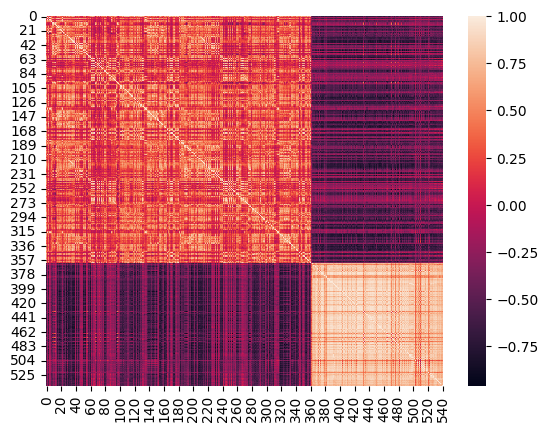

In [420]:
ndtmp=np.array(valR2_W36_PLA)
resultats = np.zeros((ndtmp.shape[0],361))
for cpt,ligne in enumerate(ndtmp):
    resultats[cpt,:]=[np.mean(ligne[glasser==x])for x in np.unique(glasser)]

set_DEF=set(df_val[df_val['GROUP']=='PLA'].index)
tmp=df[df['SUBJ_ID'].isin(set_DEF)]

mat=np.concatenate([resultats,tmp[tmp['SES']=='W36'].drop(columns=['SUBJ_ID','SES']).values],axis=1)
cov=np.corrcoef(np.transpose(mat))
   # for i in range(len(cov)):
   #     cov[i, i] = 0
   # cov_fisher = scipy.special.logit(cov)
    #plt.figure();__=plt.hist(cov.ravel(),200,range=[-.25,0.25])
    #plt.figure()
    #print(np.min(cov.ravel()),np.max(cov_fisher.ravel()))
    #plt.imshow(cov_fisher)
sns.heatmap(cov)

<Axes: >

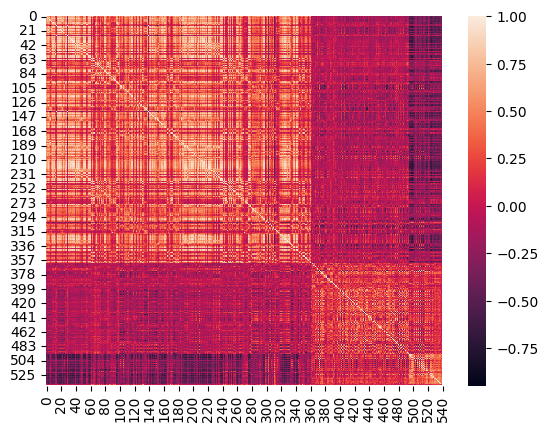

In [421]:
ndtmp=np.array(valR2_W00_PLA)
resultats = np.zeros((ndtmp.shape[0],361))
for cpt,ligne in enumerate(ndtmp):
    resultats[cpt,:]=[np.mean(ligne[glasser==x])for x in np.unique(glasser)]

set_DEF=set(df_val[df_val['GROUP']=='PLA'].index)
tmp=df[df['SUBJ_ID'].isin(set_DEF)]

mat=np.concatenate([resultats,tmp[tmp['SES']=='W00'].drop(columns=['SUBJ_ID','SES']).values],axis=1)
cov=np.corrcoef(np.transpose(mat))
   # for i in range(len(cov)):
   #     cov[i, i] = 0
   # cov_fisher = scipy.special.logit(cov)
    #plt.figure();__=plt.hist(cov.ravel(),200,range=[-.25,0.25])
    #plt.figure()
    #print(np.min(cov.ravel()),np.max(cov_fisher.ravel()))
    #plt.imshow(cov_fisher)
sns.heatmap(cov)